In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
np.random.seed(42)

n_samples = 100
mean0, var0 = [-2, -2], 1
mean1, var1 = [2, 2], 0.5

# Generate Class 0
X0 = np.random.multivariate_normal(mean0, np.eye(2) * var0, n_samples)
y0 = np.zeros(n_samples)

# Generate Class 1
X1 = np.random.multivariate_normal(mean1, np.eye(2) * var1, n_samples)
y1 = np.ones(n_samples)

# Combine and add bias term (column of 1s)
X = np.vstack((X0, X1))
y = np.concatenate((y0, y1))
X_bias = np.hstack([np.ones((X.shape[0], 1)), X])

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_loss(X, y, theta):
    m = len(y)
    h = sigmoid(X @ theta)
    epsilon = 1e-15  # prevent log(0)
    loss = -(1/m) * np.sum(y * np.log(h + epsilon) + (1 - y) * np.log(1 - h + epsilon))
    return loss

def gradient_descent(X, y, lr=0.1, epochs=1000):
    m, n = X.shape
    theta = np.zeros(n)
    loss_history = []

    for _ in range(epochs):
        predictions = sigmoid(X @ theta)
        gradient = (1/m) * (X.T @ (predictions - y))
        theta -= lr * gradient
        loss_history.append(compute_loss(X, y, theta))
        
    return theta, loss_history

# Train the model
theta_final, losses = gradient_descent(X_bias, y)

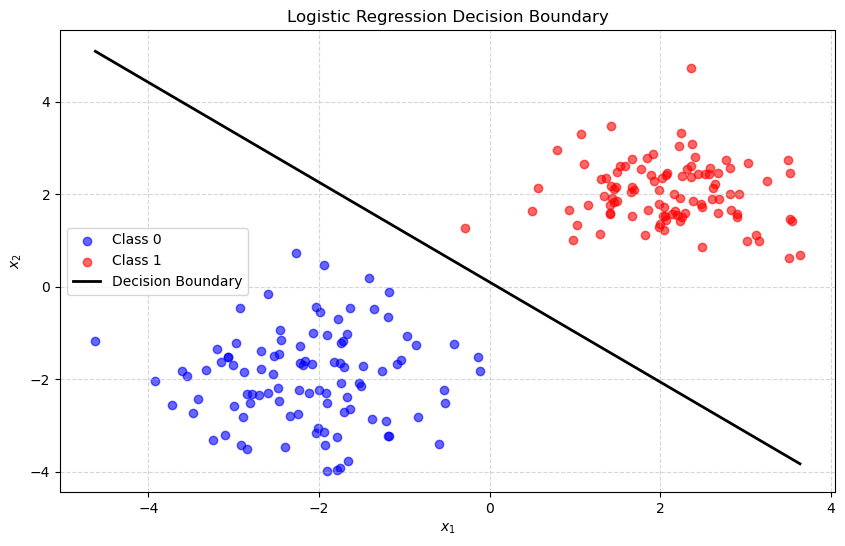

In [9]:
plt.figure(figsize=(10, 6))

# Plot clusters
plt.scatter(X0[:, 0], X0[:, 1], color='blue', label='Class 0', alpha=0.6)
plt.scatter(X1[:, 0], X1[:, 1], color='red', label='Class 1', alpha=0.6)

# Plot Decision Boundary
x1_vals = np.array([np.min(X[:, 0]), np.max(X[:, 0])])
x2_vals = -(theta_final[0] + theta_final[1] * x1_vals) / theta_final[2]

plt.plot(x1_vals, x2_vals, color='black', lw=2, label='Decision Boundary')

plt.title("Logistic Regression Decision Boundary")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [11]:
def train_sgd(X, y, batch_size, lr=0.1, epochs=50):
    m, n = X.shape
    theta = np.zeros(n)
    loss_history = []
    acc_history = []

    for epoch in range(epochs):
        indices = np.random.permutation(m)
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        for i in range(0, m, batch_size):
            xi = X_shuffled[i:i+batch_size]
            yi = y_shuffled[i:i+batch_size]
            
            predictions = sigmoid(xi @ theta)
            gradient = (1/len(yi)) * (xi.T @ (predictions - yi))
            theta -= lr * gradient
            
        current_loss = compute_loss(X, y, theta)
        preds_all = (sigmoid(X @ theta) >= 0.5).astype(int)
        accuracy = np.mean(preds_all == y)
        
        loss_history.append(current_loss)
        acc_history.append(accuracy)
        
    return loss_history, acc_history

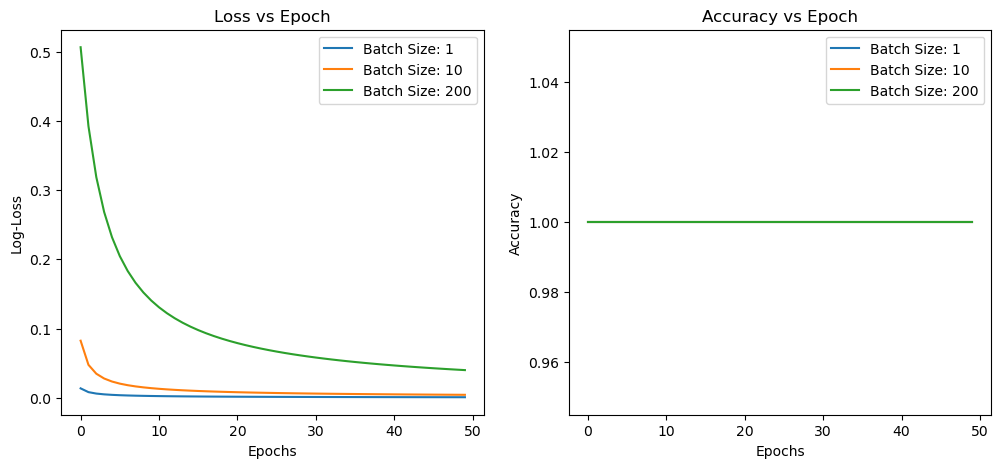

In [12]:
batch_sizes = [1, 10, len(y)]
results = {}

for b in batch_sizes:
    results[b] = train_sgd(X_bias, y, batch_size=b)

# Plotting Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for b in batch_sizes:
    plt.plot(results[b][0], label=f'Batch Size: {b}')
plt.title('Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Log-Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
for b in batch_sizes:
    plt.plot(results[b][1], label=f'Batch Size: {b}')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
def evaluate_model(X, y, theta, threshold=0.5):
    probs = sigmoid(X @ theta)
    
    y_pred = (probs >= threshold).astype(int)
    
    tp = np.sum((y == 1) & (y_pred == 1))
    tn = np.sum((y == 0) & (y_pred == 0))
    fp = np.sum((y == 0) & (y_pred == 1))
    fn = np.sum((y == 1) & (y_pred == 0))
    
    accuracy = (tp + tn) / len(y)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        "Threshold": threshold,
        "Matrix (TP,FP,FN,TN)": (tp, fp, fn, tn),
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }

In [14]:
thresholds = [0.3, 0.5, 0.7]
evaluations = []

for t in thresholds:
    res = evaluate_model(X_bias, y, theta_final, threshold=t)
    evaluations.append(res)

# Visualizziamo i risultati in una tabella semplice
import pandas as pd
df = pd.DataFrame(evaluations)
print(df.to_string(index=False))

 Threshold Matrix (TP,FP,FN,TN)  Accuracy  Precision  Recall  F1-Score
       0.3     (100, 0, 0, 100)       1.0        1.0     1.0       1.0
       0.5     (100, 0, 0, 100)       1.0        1.0     1.0       1.0
       0.7     (100, 0, 0, 100)       1.0        1.0     1.0       1.0
